# DP-SurfaceDetection - Training run


In [1]:
import os
import json
import glob
import numpy as np
import random as rand
import librosa
import librosa.display
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils import data
import torchvision.transforms as T

%load_ext autoreload
%autoreload 2
from decoder import Decoder
from encoder import Encoder
from discriminator import Discriminator
from train import *
from torch.utils.data import *
from train import *
from plotter import Plotter


In [17]:
from functools import reduce

class NSynthDataset(data.Dataset):
    def __init__(self, root, transform=None, target_transform=None, domains=['']):
        self.root = root
        self.transform=transform
        self.target_transform = None
        self.domains = domains
        self.filenames = reduce((lambda a, b: a + b), 
                                map(lambda domain: glob.glob(os.path.join(root, "audio/" + domain  + "*.wav")), domains))
        with open(os.path.join(root, "examples.json"), "r") as f:
            self.json_data = json.load(f)
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, i):
        sample = self.get_spectrogram(i)
        target = self.get_target(i)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        augmented_sample = sample
        return sample, augmented_sample, target
    
    def get_spectrogram(self, i, n_mels=128, sr=16000, fmax=8000):
        y, _ = librosa.load(self.get_name(i), sr=sr)
        return librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    
    def get_name(self, i):
        return self.filenames[i]
    
    def get_target_str(self, i):
        data = self.json_data[os.path.splitext(os.path.basename(self.get_name(i)))[0]]
        return data['instrument_family_str'] + '_' + data['instrument_source_str']

    def get_target_str_full(self, i):
        data = self.json_data[os.path.splitext(os.path.basename(self.get_name(i)))[0]]
        return data['instrument_str']
    
    def get_target(self, i):
        target = self.get_target_str(i)
        if target in self.domains:
            return self.domains.index(target)
        else:
            return -1

In [3]:
def plot_spectrogram(S, title=None, sr=16000, fmax=8000):
    plt.figure(figsize=(10, 4))
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.title(title)
    plt.show()

In [19]:
transform = T.Compose([
                T.ToTensor(), 
                nn.ConstantPad2d((0, 2), 0), # To get the size to be 128x128
                T.Normalize((5.598382777731995,), (71.13882950507647,), inplace=True) 
])

dataset = NSynthDataset(root='nsynth-test', transform=transform)

%matplotlib inline
print(dataset.get_name(6))
#plot_spectrogram(dataset.get_spectrogram(6), title=dataset.get_name(6))

nsynth-test/audio/bass_synthetic_098-079-050.wav


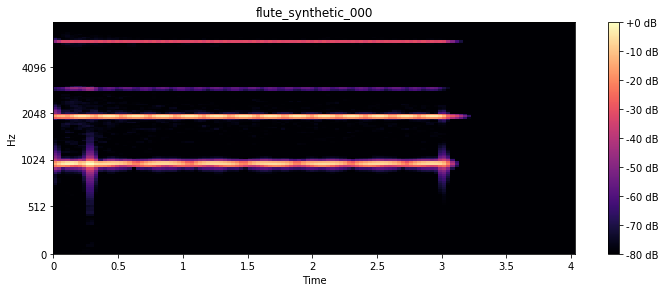

Total number of samples: 2483
Number of training samples: 1863
Number of validation samples: 372
Number of testing samples: 248


In [5]:
val_ratio = 0.15
test_ratio = 0.1

domains = ['flute_synthetic','bass_synthetic'] #flute_synthetic
dataset = NSynthDataset(root='nsynth-test', transform=transform, domains=domains)

test_number = rand.randrange (0,len(dataset[0]),1)
# test_number = 315

plot_spectrogram(dataset.get_spectrogram(test_number), title=dataset.get_target_str_full(test_number))
n_samples = len(dataset)
n_val_samples = int(n_samples*val_ratio)
n_test_samples = int(n_samples*test_ratio)
n_train_samples = n_samples-n_val_samples-n_test_samples

train_dataset, val_dataset, test_dataset = random_split(dataset, [n_train_samples, n_val_samples, n_test_samples])

print("Total number of samples: {}".format(len(dataset)))
print("Number of training samples: {}".format(len(train_dataset)))
print("Number of validation samples: {}".format(len(val_dataset)))
print("Number of testing samples: {}".format(len(test_dataset)))

In [6]:
# Test for the sampler
from sampler import MusicBatchSampler

def test_sampler():
    sampler = MusicBatchSampler(data_source=test_dataset,batch_size=10)

    seen_indices = []

    for batch in sampler:    
        targets = []

        for i in batch:
            targets.append(dataset.get_target(i))

            # Assert that this index has not been seen before
            assert(i not in seen_indices)
            seen_indices.append(i)

        targets = np.array(targets)

        assert((targets == targets[0]).all())
        assert(len(batch) == sampler.batch_size)
        
test_sampler()

In [39]:
def create_dataset(domain, root='nsynth-test'):
    dataset = NSynthDataset(root=root, transform=transform, domains=domain)
    print("Total number of samples in dataset for domain \"{}\": {}".format(domain, len(dataset)))
    return dataset

def create_loaders_for_domain(domain, root='nsynth-test',bs=16):
    
    dataset = NSynthDataset(root=root, transform=transform, domains=domain)

    test_number = rand.randrange (0,len(dataset),1)
    #plot_spectrogram(dataset.get_spectrogram(test_number), title=dataset.get_target_str(test_number))
    
    val_ratio = 0.15
    test_ratio = 0.1
    n_samples = len(dataset)
    n_val_samples = int(n_samples*val_ratio)
    n_test_samples = int(n_samples*test_ratio)
    n_train_samples = n_samples-n_val_samples-n_test_samples

    train_dataset, val_dataset, test_dataset = random_split(dataset, [n_train_samples, n_val_samples, n_test_samples])

    print("Total number of samples: {}".format(len(dataset)))
    print("Number of training samples: {}".format(len(train_dataset)))
    print("Number of validation samples: {}".format(len(val_dataset)))
    print("Number of testing samples: {}".format(len(test_dataset)))
    
    print("Creating data loaders for {}...".format(domain), end="\r")
    train_loader = DataLoader(train_dataset, batch_sampler=MusicBatchSampler(data_source=train_dataset,batch_size=bs))
    val_loader = DataLoader(val_dataset, batch_sampler=MusicBatchSampler(data_source=val_dataset,batch_size=bs))
    test_loader = DataLoader(val_dataset, batch_sampler=MusicBatchSampler(data_source=test_dataset,batch_size=len(test_dataset)))
    print("Creating data loaders ... [Done]")
    
    return train_loader, val_loader, test_loader
    

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu
